# Homework #6
Due 11:59 pm EST, Friday April 8th, 2022.

Email your solutions (both .ipnb and .html files) to: compscbio@gmail.com.

### Background:

A wise, less-sadistic post-doc in your collaborator's lab has generated scRNAseq data from HSPCs _exactly_ as was done in the Weinreb et al 2020 paper. (in fact, it is the same data). She has asked you to analyze it using CoSpar to address the two questions listed below.

### The data
1. [scRNAseq data of hematopoietic stem with lineage barcodes](https://compstemcellbio.s3.amazonaws.com/2022/homework/06/adata_cospar_hspc.h5ad)
This is the raw counts data, as well as lineage barcodes, as we discussed in the lineage tracing lectures.

2. There is _no_ second data set for this homework.


### Your mission:

Analyze the data to answer the following questions

1.) What genes distinguish undifferentiated cells biased towards erythrocytes versus megakaryocytes?

2.) What genes distinguish undifferentiated cells biased towards erythrocytes AND megakaryocytes versus those undifferentiated cells biased towards monocytes AND neutrophils?

### Bonus (i.e. extra credit)

3.) What genes distinguish the most multipotent cells from more fate bound but still undifferentiated cells?

4.) Are any signaling pathways enriched in any of the differential expression analyses that you performed in #1-#3? The underlying hypothesis here is that fate biases result from exposure to different signaling mileus. You might explore this using GSEAPY or using the `sc.tl.score_genes()`. Here is a [list of signaling pathway targets](https://compstemcellbio.s3.amazonaws.com/2022/data/signaling_pathway_targets_040122.joblib), which might be helpful. It was derived as described in [Emily Su's paper](https://pubmed.ncbi.nlm.nih.gov/35090587/). You can load this dict object with the following code 

`from joblib import dump, load
sigPathTargets  = load("signaling_pathway_targets_040122.joblib")`

### Important notes:

1.) The first time that you run a CoSpar analysis, run the `cs.hf.set_up_folders()` function. This will set up some directories that CoSpar assumes are in place.

2.) To answer these questions, you will need to identify the undifferentiated cells that are likely to transition to either of these lineages. Please look at the updated Jupyter Notebook for CoSpar analysis as it contains some code that we did not cover in class to specifcially isolate fate biased progenitors.

3.) You may need to adjust some parameters such as sum_fate_prob_thresh in the `tl.fate_bias()`. Same is true when defining differentially expressed genes. 

4.) The CoSpar documentation might be helpful if you get stuck or want to dig deeper.


In [1]:
# import 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings

warnings.filterwarnings('ignore')

import cospar as cs
cs.settings.verbosity=2

In [2]:
cs.settings.set_figure_params()

In [3]:
cs.hf.set_up_folders()

In [4]:
# load in the adata
adata_orig = sc.read_h5ad('adata_cospar_hspc.h5ad')

In [5]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_emb', 'X_pca'

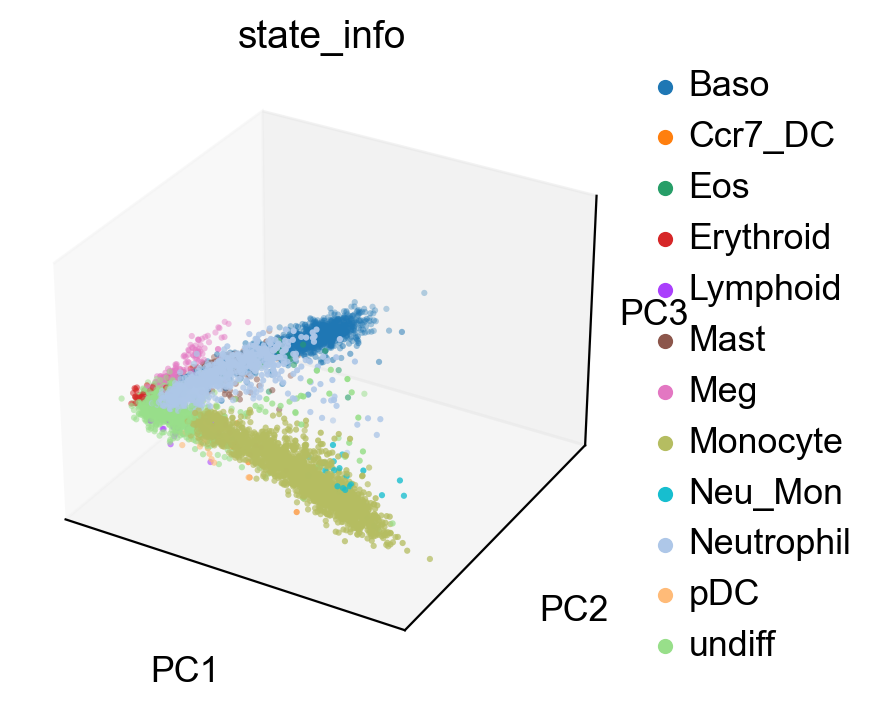

In [6]:
sc.pl.pca(adata_orig, color='state_info', projection='3d')

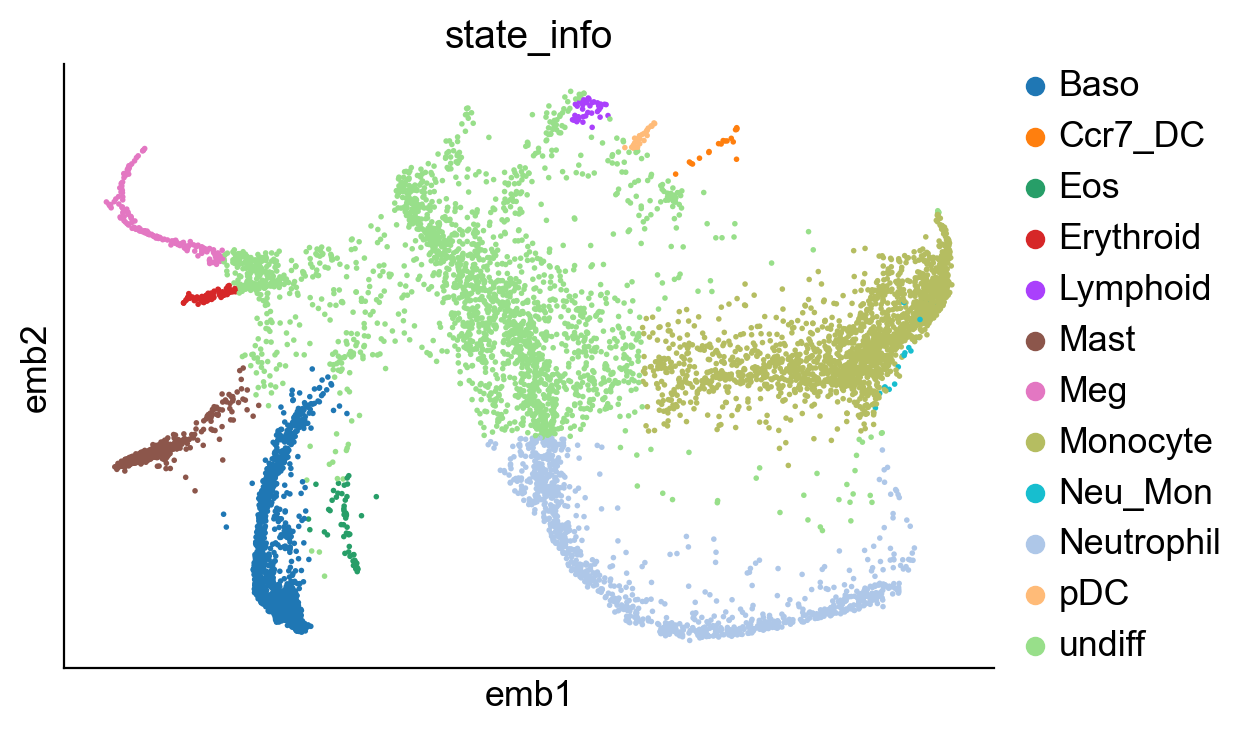

In [7]:
sc.pl.embedding(adata_orig, basis="emb",color="state_info")

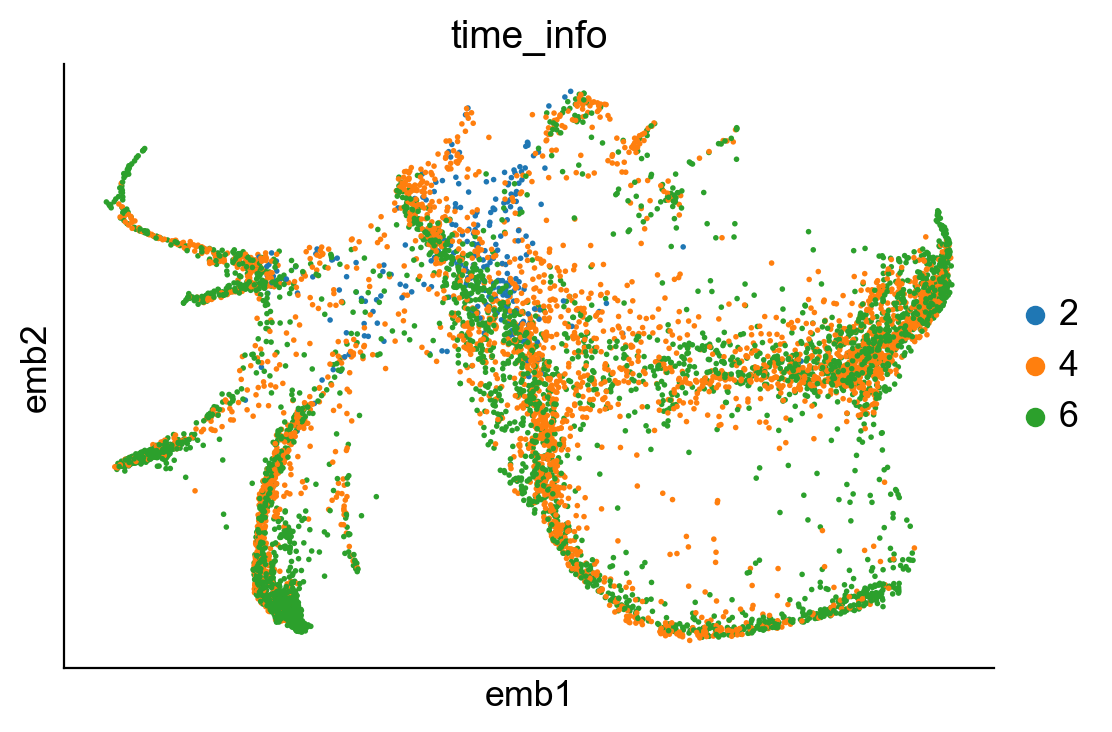

In [8]:
sc.pl.embedding(adata_orig, basis="emb",color=['time_info'])

In [9]:
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,clonal_time_points=['2','4','6'],later_time_point='6',
        smooth_array=[20,15,10],sparsity_threshold=0.2,max_iter_N=3)

# I use this function to infer tmap becuase we have multiple time points/clones and state information. 
# the other functions use just one and I think its better to use all the information we have available

------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 185
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.953
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 500
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.974
-----------Total used time: 11.698792934417725 s ------------


Results saved at adata.obs['fate_map_transition_map_Erythroid']
Results saved at adata.obs['fate_map_transition_map_Meg']


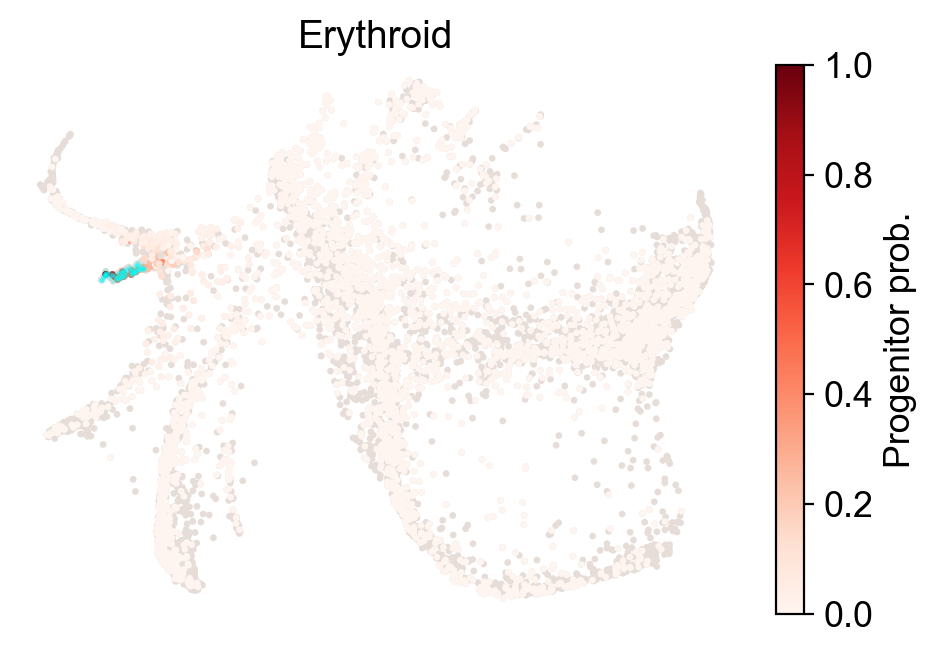

In [10]:
# compute and plot cell fate maps for eryth and meg
cs.tl.fate_map(adata,selected_fates=['Erythroid','Meg'],
               source='transition_map',map_backward=True)
cs.pl.fate_map(adata,selected_fates=['Erythroid'],
               source='transition_map',plot_target_state=True,show_histogram=False)

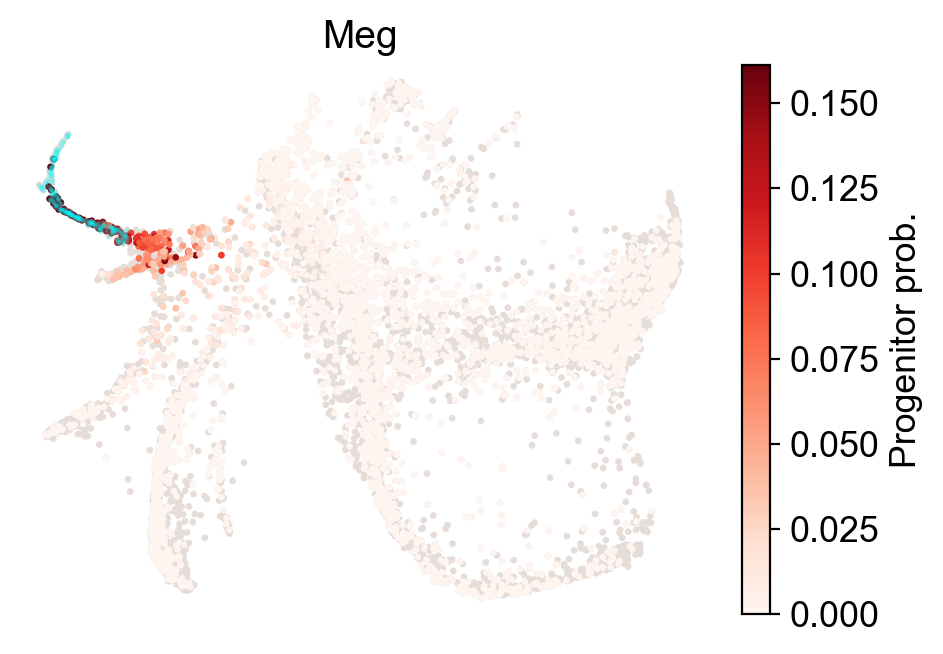

In [11]:
cs.pl.fate_map(adata,selected_fates=['Meg'],
               source='transition_map',plot_target_state=True,show_histogram=False)

The fate maps show the liklihoods of the progenitor cells in red becoming the cell type in teal. The darker the red the more likely that progenitor will become the cell type in teal.

Results saved at adata.obs['fate_map_transition_map_Baso']
Results saved at adata.obs['fate_map_transition_map_Monocyte']
Results saved at adata.obs['fate_map_transition_map_Ccr7_DC']
Results saved at adata.obs['fate_map_transition_map_pDC']
Results saved at adata.obs['fate_map_transition_map_Erythroid']
Results saved at adata.obs['fate_map_transition_map_Meg']
Results saved at adata.obs['fate_map_transition_map_Eos']
Results saved at adata.obs['fate_map_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_transition_map_Lymphoid']
Results saved at adata.obs['fate_map_transition_map_Neu_Mon']
Results saved at adata.obs['fate_map_transition_map_undiff']
Results saved at adata.obs['fate_map_transition_map_Mast']
Results saved at adata.obs['fate_potency_transition_map']


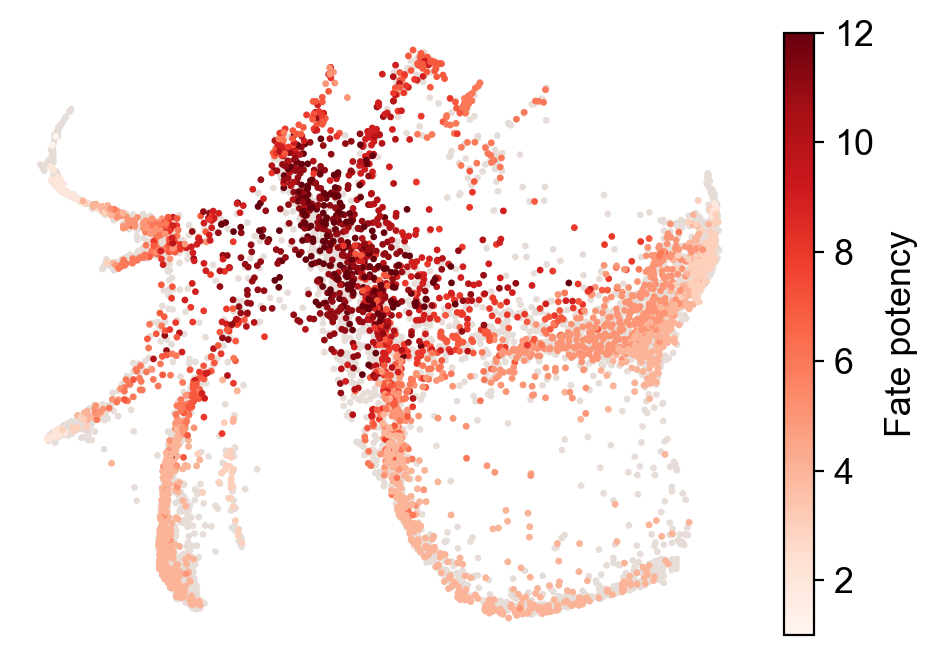

In [12]:
# compute and plot fate potency, scores multipotency of cells
cs.tl.fate_potency(adata,source='transition_map',
            map_backward=True,method='norm-sum',fate_count=True)
cs.pl.fate_potency(adata,source='transition_map')

Results saved at adata.obs['fate_map_transition_map_Erythroid']
Results saved at adata.obs['fate_map_transition_map_Meg']
Results saved at adata.obs['fate_bias_transition_map_Erythroid*Meg']


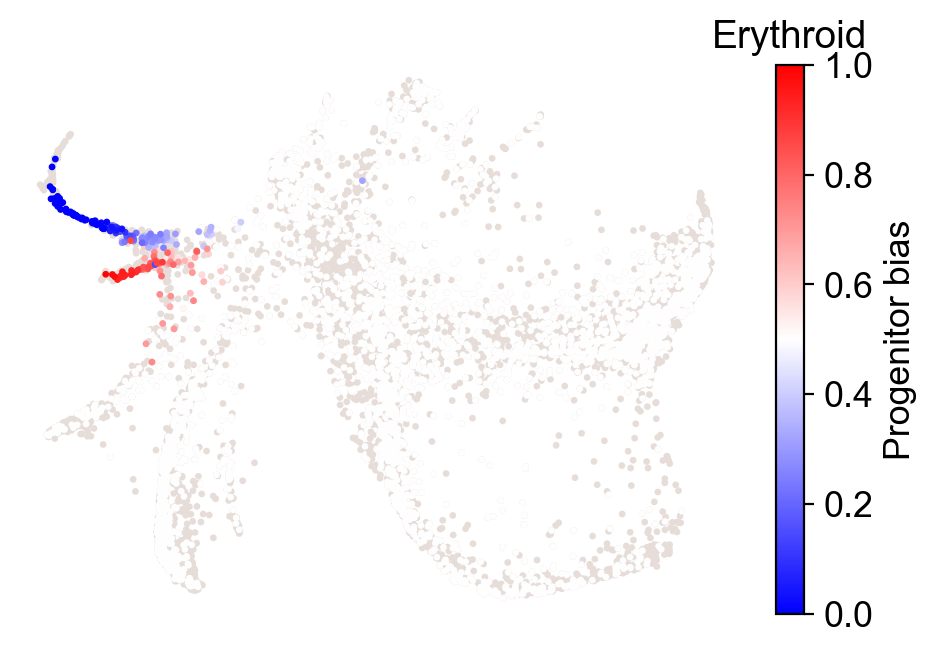

In [13]:
# fate bias
cs.tl.fate_bias(adata,selected_fates=['Erythroid','Meg'],source='transition_map',pseudo_count=0,sum_fate_prob_thresh=0.05)
cs.pl.fate_bias(adata,selected_fates=['Erythroid','Meg'],source='transition_map',plot_target_state=False,selected_times=['4'])

# fate_bias allows us to see which cell type our progen's are biased towards

Results saved as dictionary at adata.uns['fate_coupling_transition_map']


<AxesSubplot:title={'center':'source: transition_map'}>

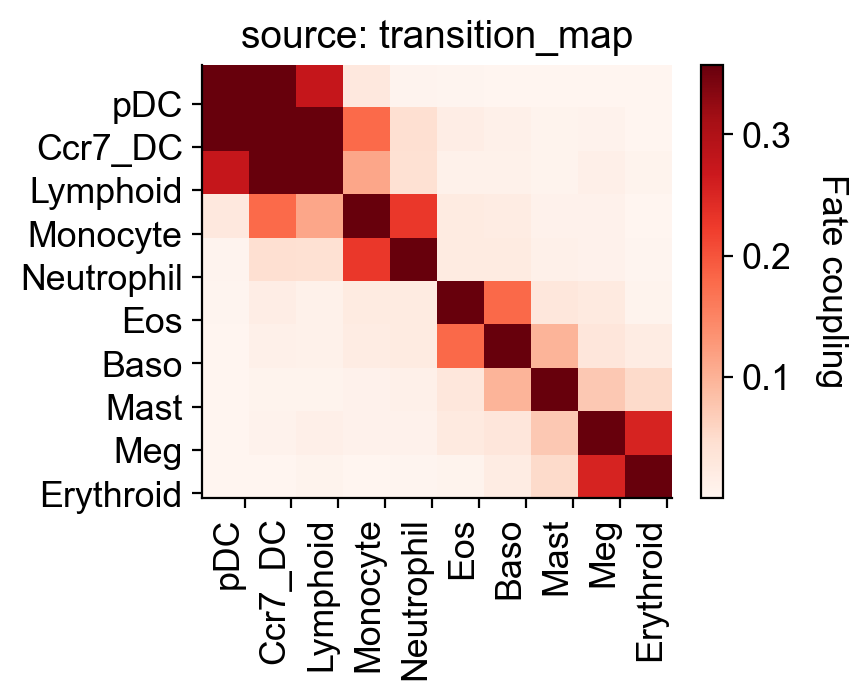

In [14]:
# fate coupling 
selected_fates=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
cs.tl.fate_coupling(adata,selected_fates=selected_fates,source='transition_map')
cs.pl.fate_coupling(adata,source='transition_map')

# eryth and meg coupling score pretty high, means that their fates are closely related 

In [15]:
# reconstruct hierarchy
cs.tl.fate_hierarchy(adata,selected_fates=selected_fates,source='transition_map')
cs.pl.fate_hierarchy(adata,source='transition_map')

# meg and eryth close together, come from similar progen cells
# for the next question, in this plot we can also see that neu and mon are closely related

Results saved as dictionary at adata.uns['fate_hierarchy_transition_map']

            /-Baso
         /-|
      /-|   \-Eos
     |  |
   /-|   \-Mast
  |  |
  |  |   /-Erythroid
  |   \-|
--|      \-Meg
  |
  |      /-Monocyte
  |   /-|
  |  |   \-Neutrophil
   \-|
     |      /-pDC
     |   /-|
      \-|   \-Ccr7_DC
        |
         \-Lymphoid


Results saved at adata.obs['fate_map_transition_map_Erythroid']
Results saved at adata.obs['fate_map_transition_map_Meg']
Results saved at adata.obs['fate_bias_transition_map_Erythroid*Meg']
Results saved at adata.obs[f'progenitor_transition_map_Erythroid'] and adata.obs[f'diff_trajectory_transition_map_Erythroid']
Results saved at adata.obs[f'progenitor_transition_map_Meg'] and adata.obs[f'diff_trajectory_transition_map_Meg']


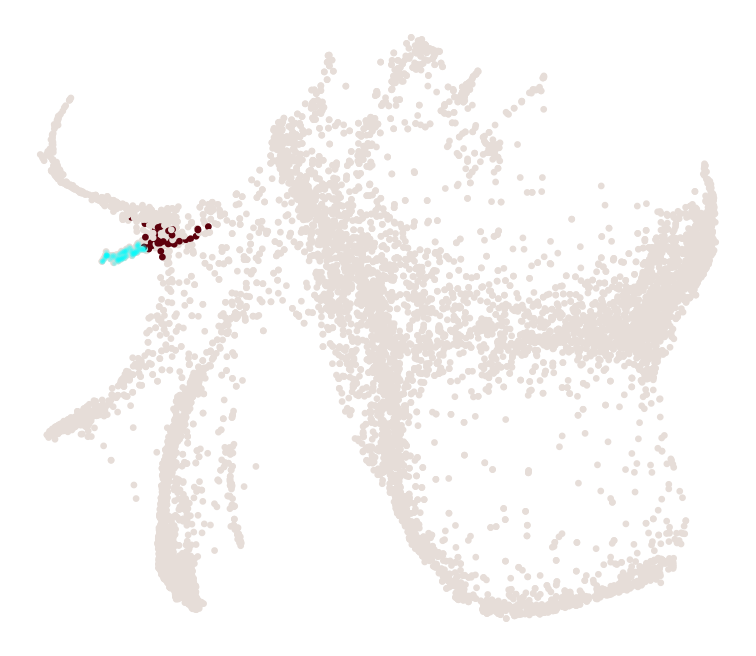

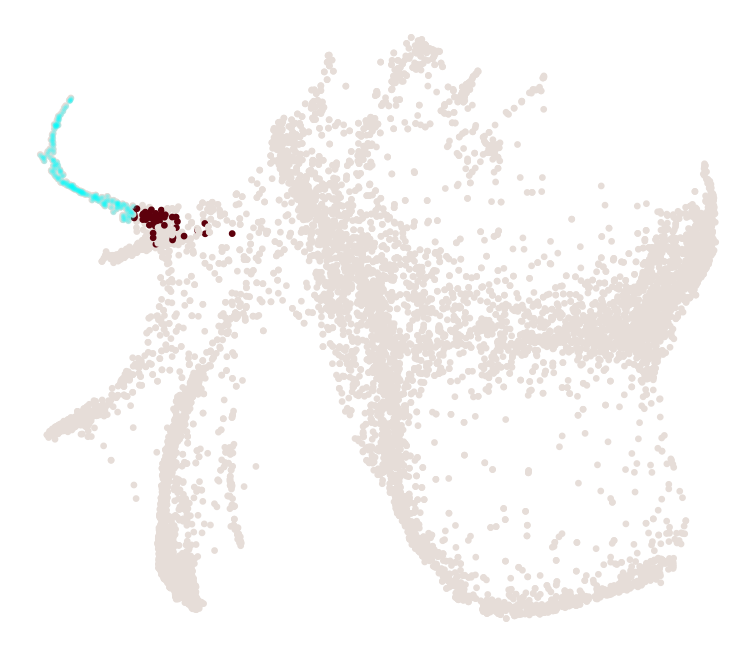

In [60]:
cs.tl.progenitor(adata, selected_fates=['Erythroid','Meg'],
 source='transition_map', map_backward=True,
    bias_threshold_A=0.5,bias_threshold_B=0.5, sum_fate_prob_thresh=0.1, avoid_target_states=True)
cs.pl.progenitor(adata, selected_fates=['Erythroid','Meg'],
 source='transition_map')

# we use tl.progenitor here because we are interested in comparing the difference between progenitors that result in our cell types of interest
# this function gives us the liklihood progens become our cells of interest

Changing sum_fate_prob_thresh to 0.1 from 0.2 gives us more progenitors. With a thresh of 0.2 we were only getting about 25 for eryth and 0 for meg. I chose this new threshold by trying a bunch of different ones and I think 0.1 gives us the "best looking" graphs because the progens are near the cell type of interest

In [63]:
sum(adata.obs[f'progenitor_transition_map_Erythroid'])

40

In [64]:
sum(adata.obs[f'progenitor_transition_map_Meg'])

50

In [65]:
# adata.obs[f'diff_trajectory_transition_map_Erythroid']

In [66]:
# adata.obs[f'diff_trajectory_transition_map_Meg']

In [67]:
cell_group_A=np.array(adata.obs['diff_trajectory_transition_map_Erythroid'])
cell_group_B=np.array(adata.obs['diff_trajectory_transition_map_Meg'])
dge_gene_A, dge_gene_B=cs.tl.differential_genes(adata,cell_group_A=cell_group_A,cell_group_B=cell_group_B,FDR_cutoff=0.05)

In [68]:
dge_gene_A

index    gene        Qvalue    mean_1     mean_2     ratio
0        1     Pf4  2.045772e-36  1.611808  55.626705 -4.438362
1       15    Ppbp  9.432767e-18  0.073409  11.136544 -3.499086
2        0  Tmsb4x  1.247951e-37  4.152899  29.316187 -2.556632
3       16  Slc6a4  9.681184e-18  0.329875   6.340041 -2.464497
4        4   Itgb3  1.892897e-28  0.112235   4.512529 -2.309253
..     ...     ...           ...       ...        ...       ...
330    414   Stat3  3.026787e-02  0.269200   0.441608 -0.183760
331    457   Anks1  4.705012e-02  0.211538   0.369970 -0.177305
332    400    Ehd1  2.434129e-02  0.125591   0.263944 -0.167249
333    454    Lyz2  4.602595e-02  0.328612   0.460095 -0.136143
334    394    Mdm2  2.284303e-02  0.554569   0.699833 -0.128878

[335 rows x 6 columns]

In [69]:
dge_gene_B

index     gene        Qvalue     mean_1     mean_2     ratio
0      114   Hbb-bs  3.426255e-06  21.762352   2.738434  2.606144
1       24   Hbb-bt  8.083694e-15  45.453178   9.089516  2.202920
2        3     Car2  4.792561e-32   5.851437   0.624406  2.076494
3      157   Hba-a2  7.291811e-05   1.836187   0.017040  1.479577
4       42     Tph1  4.135247e-11   2.728502   0.351297  1.464252
..     ...      ...           ...        ...        ...       ...
120    440     Lcp1  4.041661e-02   1.067611   0.737769  0.250728
121    226   mt-Nd4  1.513768e-03  26.590782  22.194189  0.250423
122    310     Rpl4  7.295835e-03   8.654115   7.267349  0.223719
123    416  mt-Cytb  3.061419e-02  22.825573  19.615646  0.208771
124    409   mt-Co2  2.835173e-02  66.534569  58.315563  0.187216

[125 rows x 6 columns]

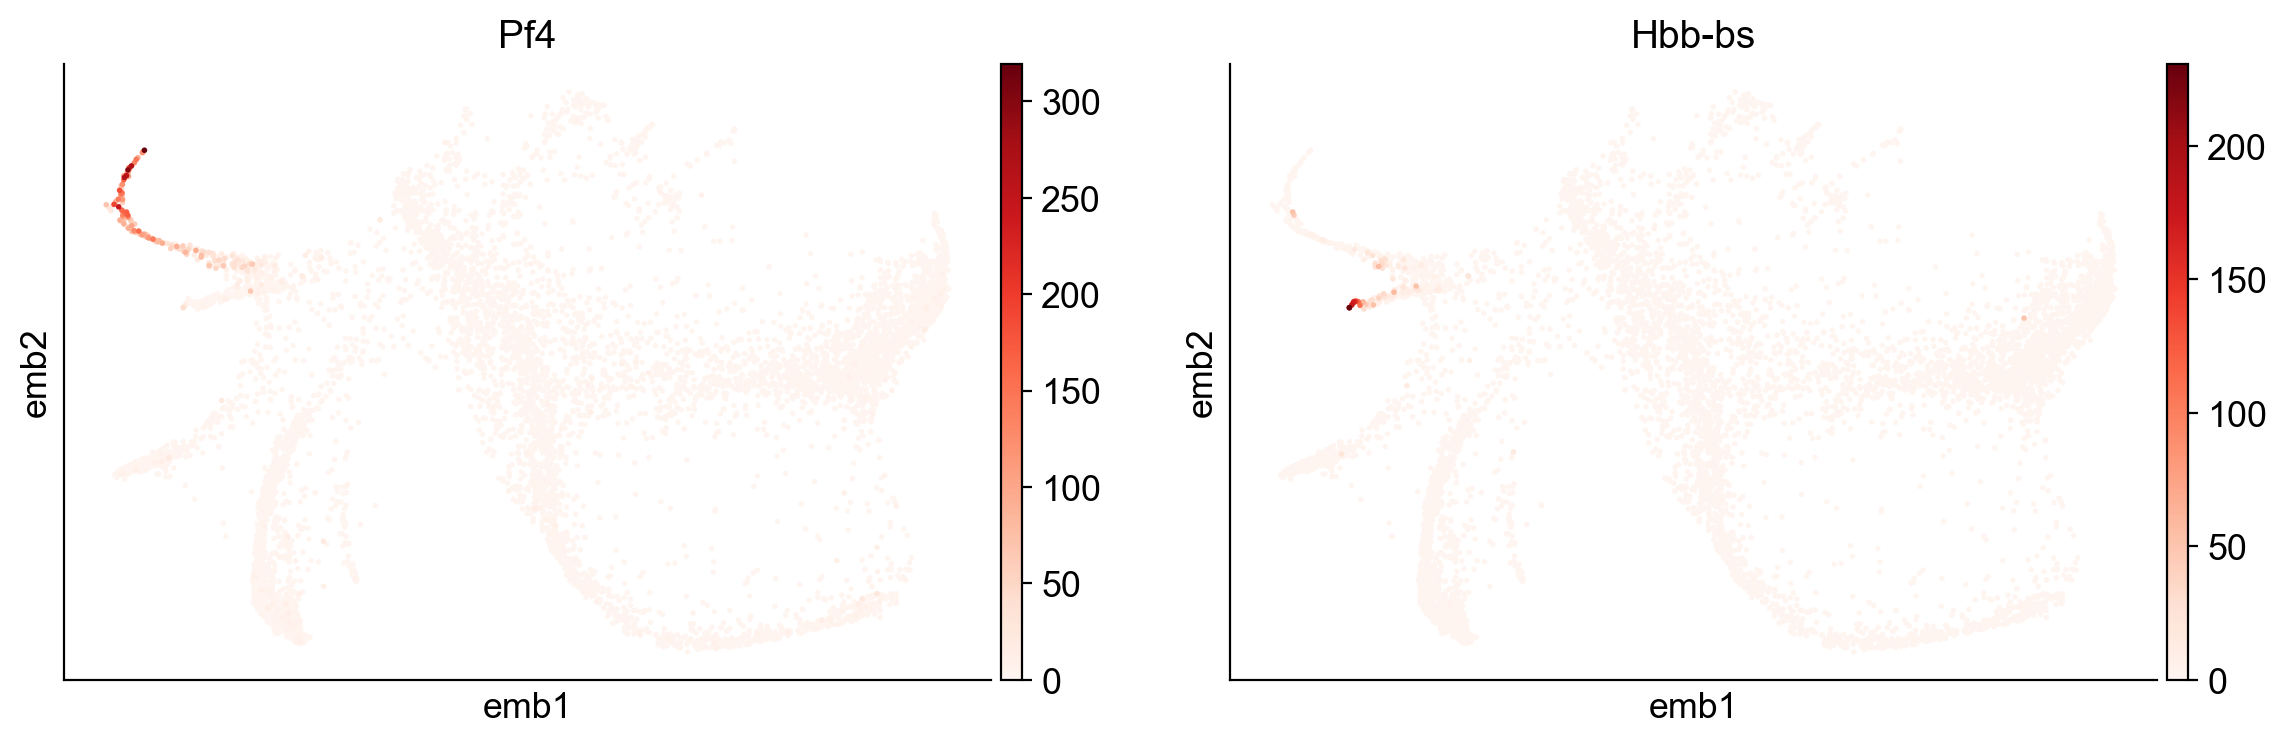

In [70]:
sc.pl.embedding(adata, basis="emb",color=['Pf4', 'Hbb-bs'])

# pf4 expression related to meg
# hbb-bs expression related to eryth

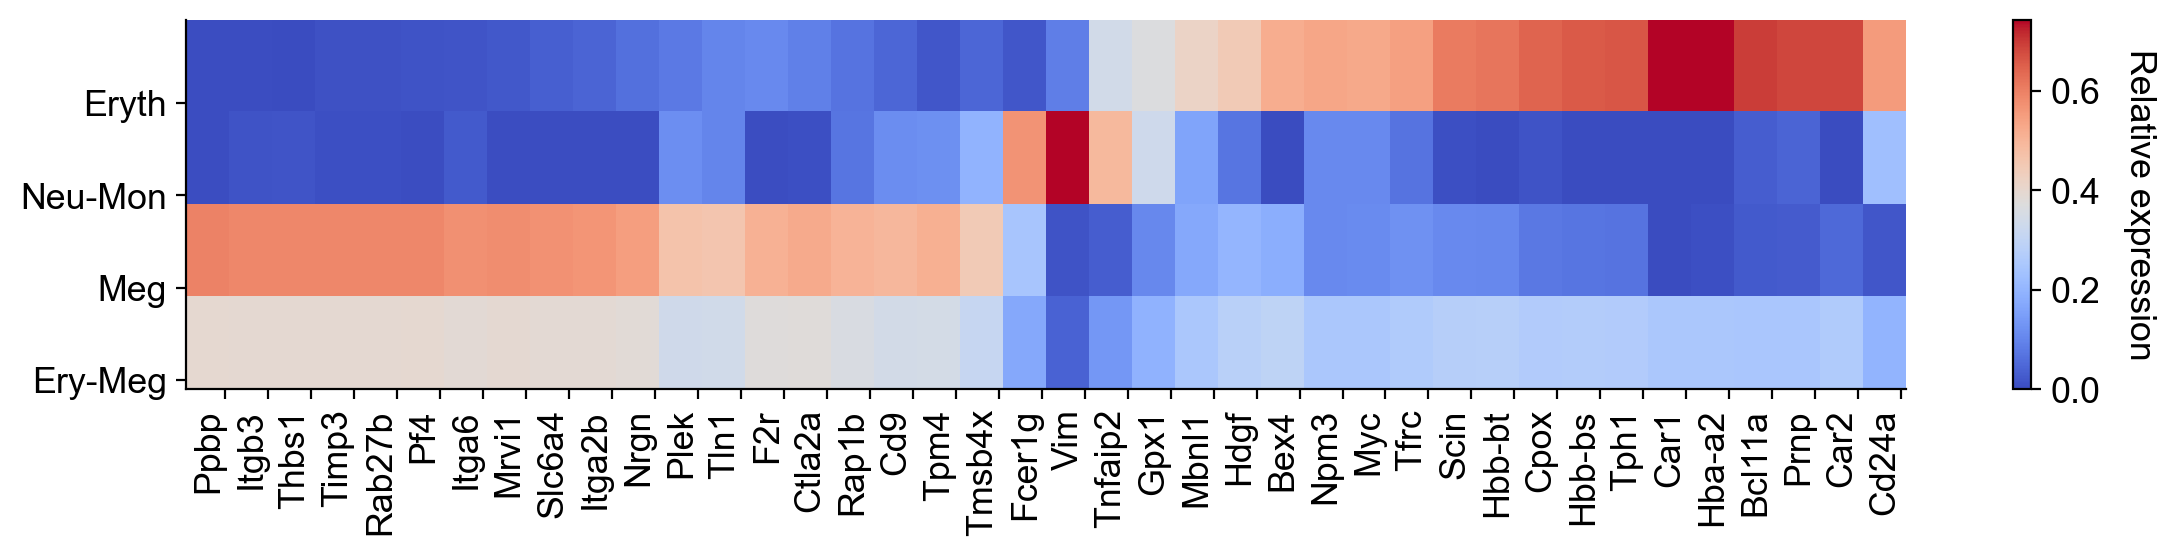

In [71]:
gene_list=list(dge_gene_A['gene'][:20])+list(dge_gene_B['gene'][:20]) #select the top 20 genes from both populations

selected_fates=['Erythroid','Meg',['Erythroid','Meg'],['Neutrophil','Monocyte']]
renames=['Eryth','Meg','Ery-Meg','Neu-Mon']
gene_expression_matrix=cs.pl.gene_expression_heatmap(adata,selected_genes=gene_list,selected_fates=selected_fates,
                            rename_fates=renames,fig_width=12)

# with this plot we can compare dge's between eryth and meg 
# can also compare erth+meg vs neu+mon

In [337]:
# undifferentiated cells that are biased
# above we looked at dge between the cell types, now we will look at dge between progens
cell_group_A=np.array(adata.obs['progenitor_transition_map_Erythroid'])
cell_group_B=np.array(adata.obs['progenitor_transition_map_Meg'])

In [338]:
# note to cell might need to adjust fdr
dge_gene_A, dge_gene_B = cs.tl.differential_genes(adata, cell_group_A=cell_group_A, cell_group_B=cell_group_B, FDR_cutoff=0.5)

In [339]:
dge_gene_A

index     gene    Qvalue    mean_1     mean_2     ratio
0      2      Pf4  0.103308  1.929086  12.392272 -2.192878
1      1     Pbx1  0.103308  1.018214   3.133059 -1.034130
2      4   Tmsb4x  0.233701  5.754030  12.256623 -0.972893
3      5   Fcer1g  0.291291  0.428542   1.655401 -0.894386
4      3    Rap1b  0.233701  2.567837   5.487566 -0.862628
5      7  Morf4l2  0.404565  0.562260   1.443966 -0.645589

In [340]:
dge_gene_B

index    gene    Qvalue     mean_1    mean_2     ratio
0      6  Hbb-bt  0.291291  11.806494  3.937246  1.375097
1      0    Car2  0.071781   3.870998  1.025600  1.265868

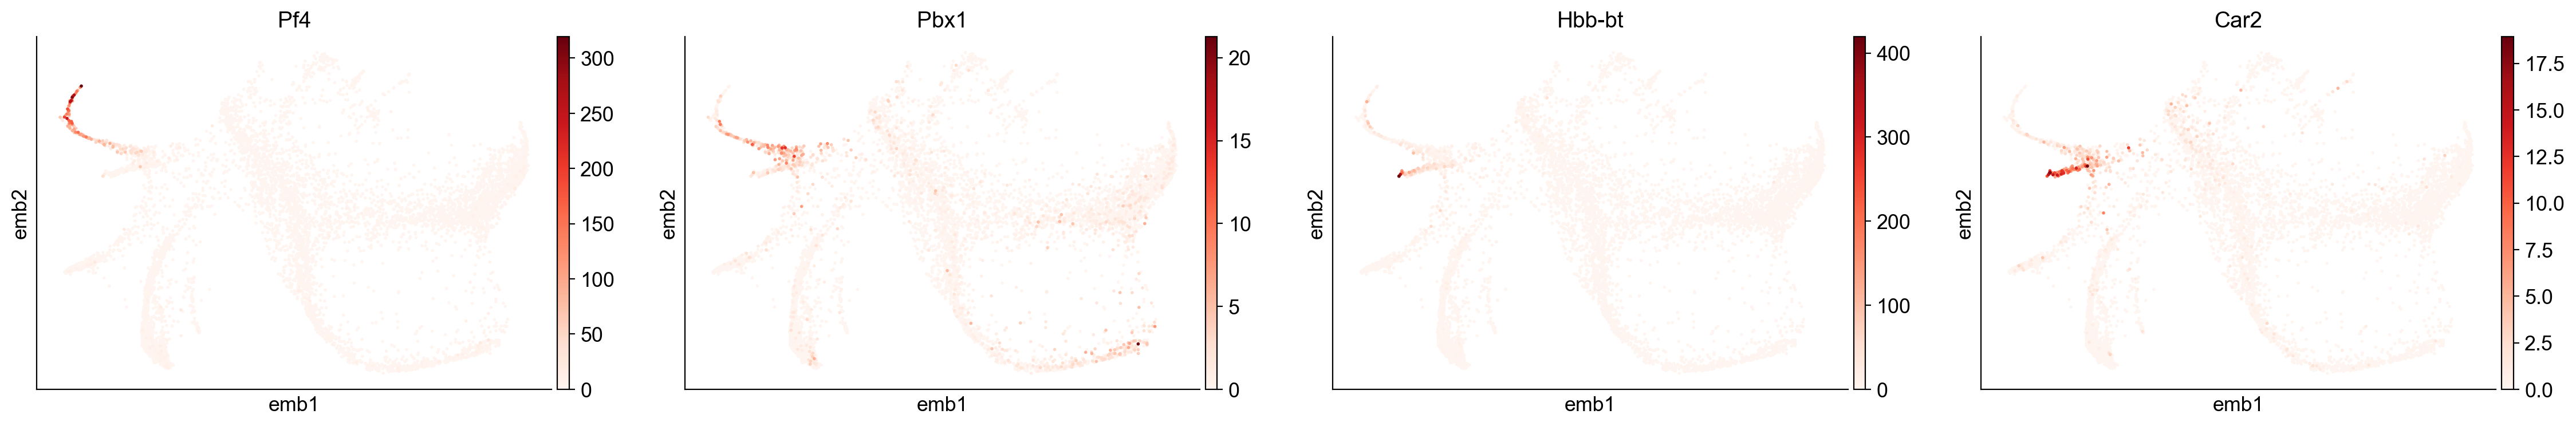

In [102]:
sc.pl.embedding(adata, basis="emb",color=['Pf4', 'Pbx1', 'Hbb-bt', 'Car2'])

I originally set the fdr to be 0.95 since we don't have that many to work with and I wanted to see all of them. But I decided on 0.5 since thats already very high but I still wanted to see more genes. Then I decided to plot the lowest two q-value genes for each dge group because group B only has 2 and group b has 2 q-vals under 0.2. Although the q values are a little high, we can still see the seperation between the two cell types pretty well.

# Q2
2.) What genes distinguish undifferentiated cells biased towards erythrocytes AND megakaryocytes versus those undifferentiated cells biased towards monocytes AND neutrophils?

Use pre-computed fate map


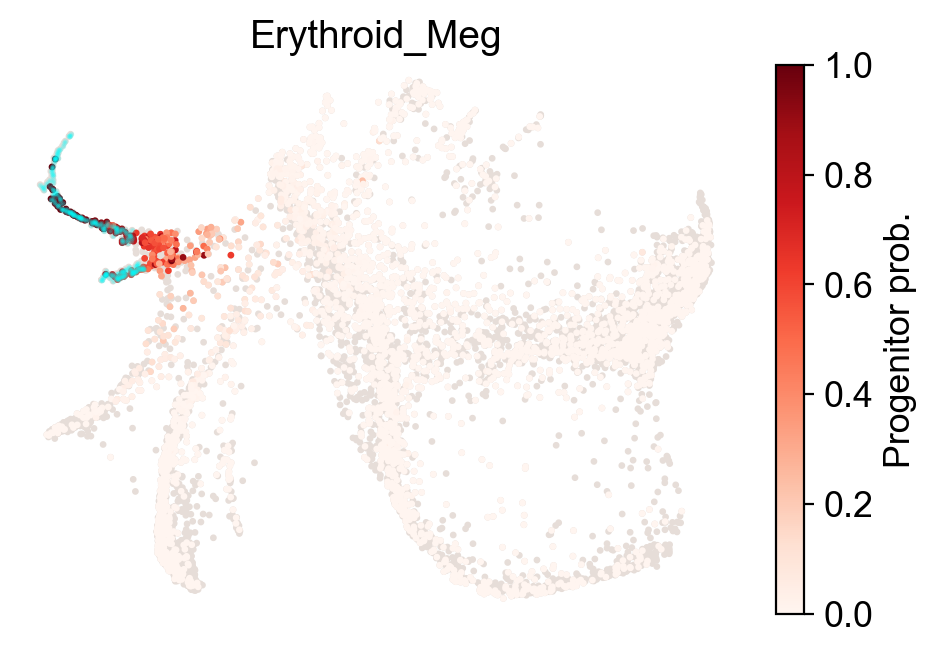

In [115]:
cs.tl.fate_map(adata,selected_fates=[['Erythroid','Meg'], ['Neutrophil','Monocyte']],
               source='transition_map',map_backward=True)
cs.pl.fate_map(adata,selected_fates=[['Erythroid','Meg']],
               source='transition_map',plot_target_state=True,show_histogram=False)

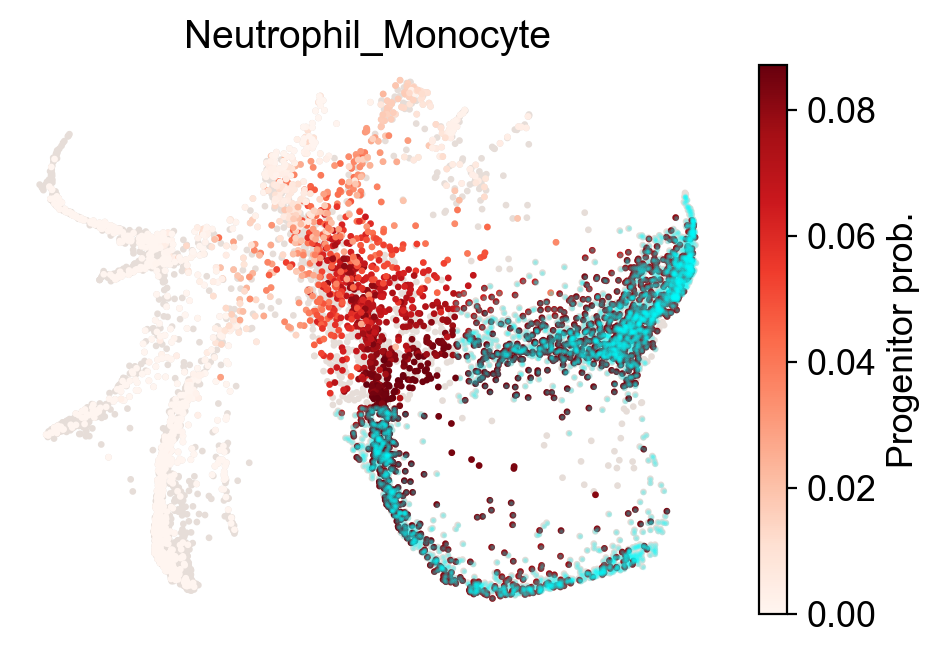

In [116]:
cs.pl.fate_map(adata,selected_fates=[['Neutrophil','Monocyte']],
               source='transition_map',plot_target_state=True,show_histogram=False)

Results saved at adata.obs['fate_map_transition_map_Erythroid_Meg']
Results saved at adata.obs['fate_map_transition_map_Neutrophil_Monocyte']
Results saved at adata.obs['fate_bias_transition_map_Erythroid_Meg*Neutrophil_Monocyte']


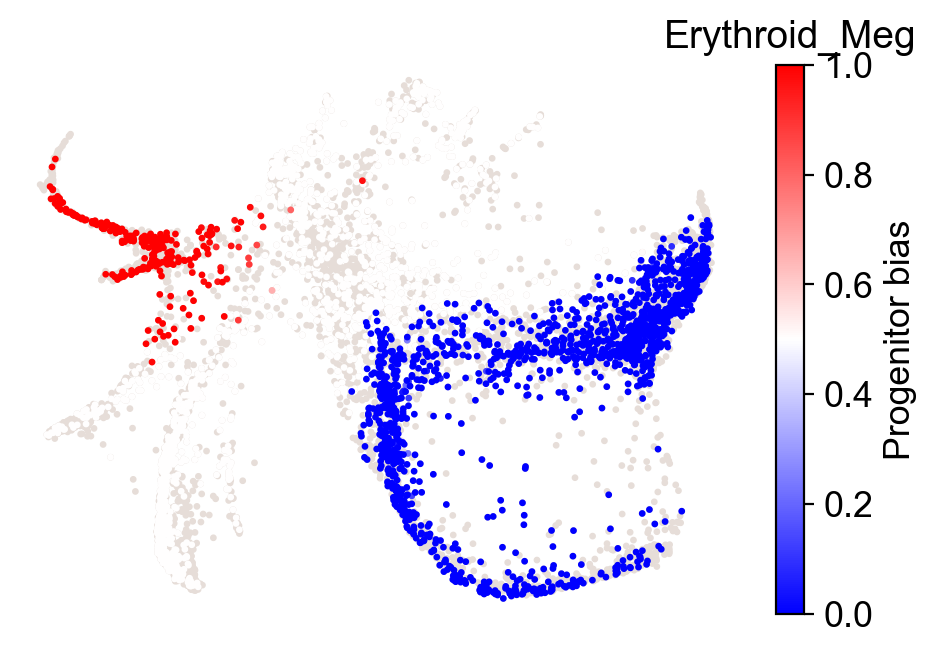

In [117]:
cs.tl.fate_bias(adata,selected_fates=[['Erythroid','Meg'], ['Neutrophil','Monocyte']],source='transition_map',pseudo_count=0,sum_fate_prob_thresh=0.075)
cs.pl.fate_bias(adata,selected_fates=[['Erythroid','Meg'], ['Neutrophil','Monocyte']],source='transition_map',plot_target_state=False,selected_times=['4'])

Results saved at adata.obs['fate_map_transition_map_Erythroid_Meg']
Results saved at adata.obs['fate_map_transition_map_Neutrophil_Monocyte']
Results saved at adata.obs['fate_bias_transition_map_Erythroid_Meg*Neutrophil_Monocyte']
Results saved at adata.obs[f'progenitor_transition_map_Erythroid_Meg'] and adata.obs[f'diff_trajectory_transition_map_Erythroid_Meg']
Results saved at adata.obs[f'progenitor_transition_map_Neutrophil_Monocyte'] and adata.obs[f'diff_trajectory_transition_map_Neutrophil_Monocyte']


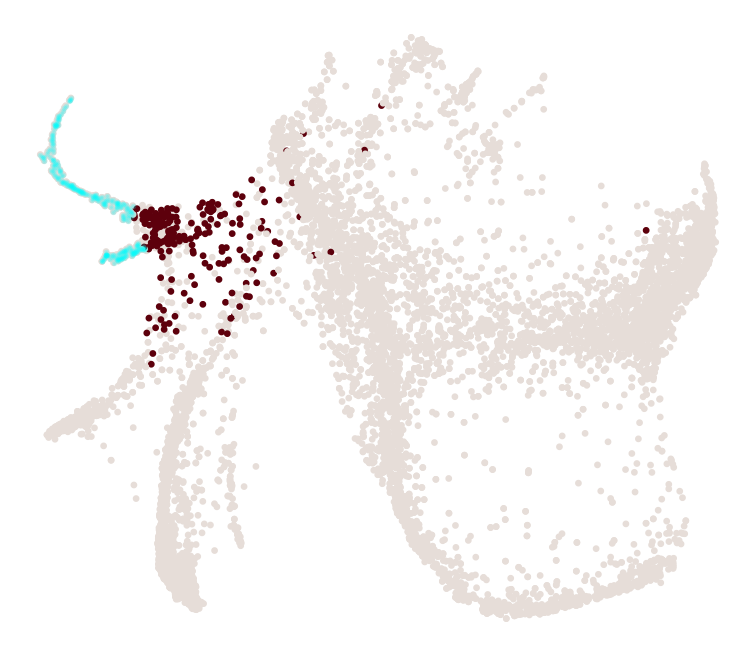

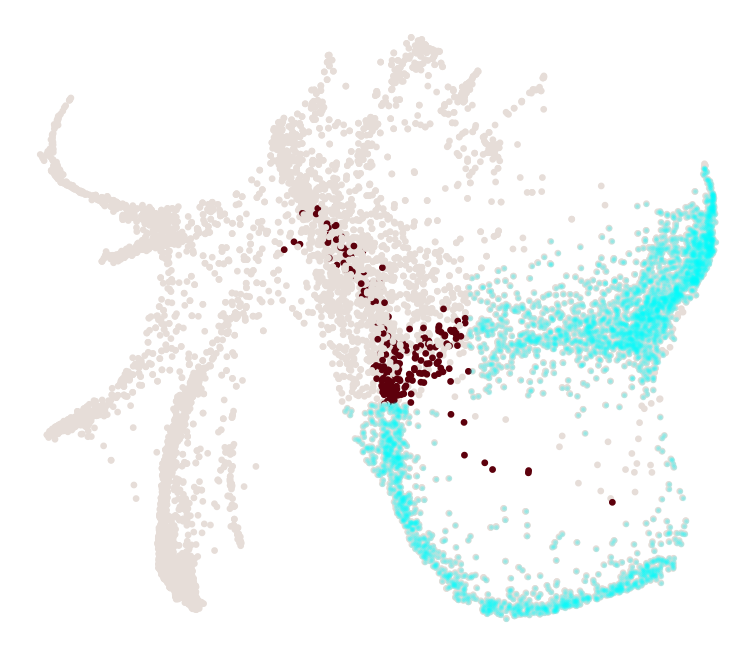

In [216]:
cs.tl.progenitor(adata, selected_fates=[['Erythroid','Meg'],['Neutrophil','Monocyte']],
 source='transition_map', map_backward=True,
    bias_threshold_A=0.5,bias_threshold_B=0.5, sum_fate_prob_thresh=0.08, avoid_target_states=True)
cs.pl.progenitor(adata, selected_fates=[['Erythroid','Meg'],['Neutrophil','Monocyte']],
 source='transition_map')

# lowered the sum_fate_prob_thresh as not many progens were showing up for mon and neut and higher ones

In [217]:
cell_group_A=np.array(adata.obs['diff_trajectory_transition_map_Erythroid_Meg'])
cell_group_B=np.array(adata.obs['diff_trajectory_transition_map_Neutrophil_Monocyte'])
dge_gene_A, dge_gene_B=cs.tl.differential_genes(adata,cell_group_A=cell_group_A,cell_group_B=cell_group_B,FDR_cutoff=0.01)

# since we have lots of genes we can lower the fdr to make sure our genes are accurate

In [218]:
dge_gene_A

index    gene         Qvalue    mean_1     mean_2     ratio
0        89  S100a9   1.435344e-65  0.837929  43.544250 -4.599086
1        47  S100a8   9.702013e-90  0.506331  28.322664 -4.282906
2         1    Lyz2  4.228226e-194  0.340418  23.037336 -4.164522
3       658     Ngp   4.075921e-14  0.675114  26.083008 -4.015057
4        42    Mmp8   5.990007e-95  0.015748   8.600425 -3.240556
...     ...     ...            ...       ...        ...       ...
1028   1871   Adap1   1.820777e-03  0.060178   0.137775 -0.101908
1029   2241   Mkrn1   9.725968e-03  0.471148   0.576734 -0.099997
1030   1986    Ubl5   3.246651e-03  0.677890   0.791270 -0.094335
1031   2108   Sel1l   5.165026e-03  0.312439   0.392431 -0.085355
1032   2181   Cers6   7.442150e-03  0.103689   0.158258 -0.069623

[1033 rows x 6 columns]

In [219]:
dge_gene_B

index    gene         Qvalue     mean_1    mean_2     ratio
0       124     Pf4   1.559853e-53  26.786932  0.471597  4.238952
1        20  Hbb-bt  6.754491e-124  17.301077  0.062190  4.106815
2       507  Hbb-bs   1.961570e-18   7.107498  0.026113  2.982068
3       500    Ppbp   1.064408e-18   5.262504  0.074317  2.543320
4        11     F2r  3.945688e-139   4.061679  0.047856  2.272176
...     ...     ...            ...        ...       ...       ...
1214   2240     Ryk   9.650709e-03   0.079360  0.003882  0.104586
1215   2071  Map2k7   4.553384e-03   0.249524  0.162367  0.104313
1216   2206  Commd3   8.215315e-03   0.342440  0.254046  0.098268
1217   2097    Hscb   4.994844e-03   0.177330  0.100553  0.097290
1218   2100  Dnmt3a   5.043321e-03   0.227154  0.174165  0.063682

[1219 rows x 6 columns]

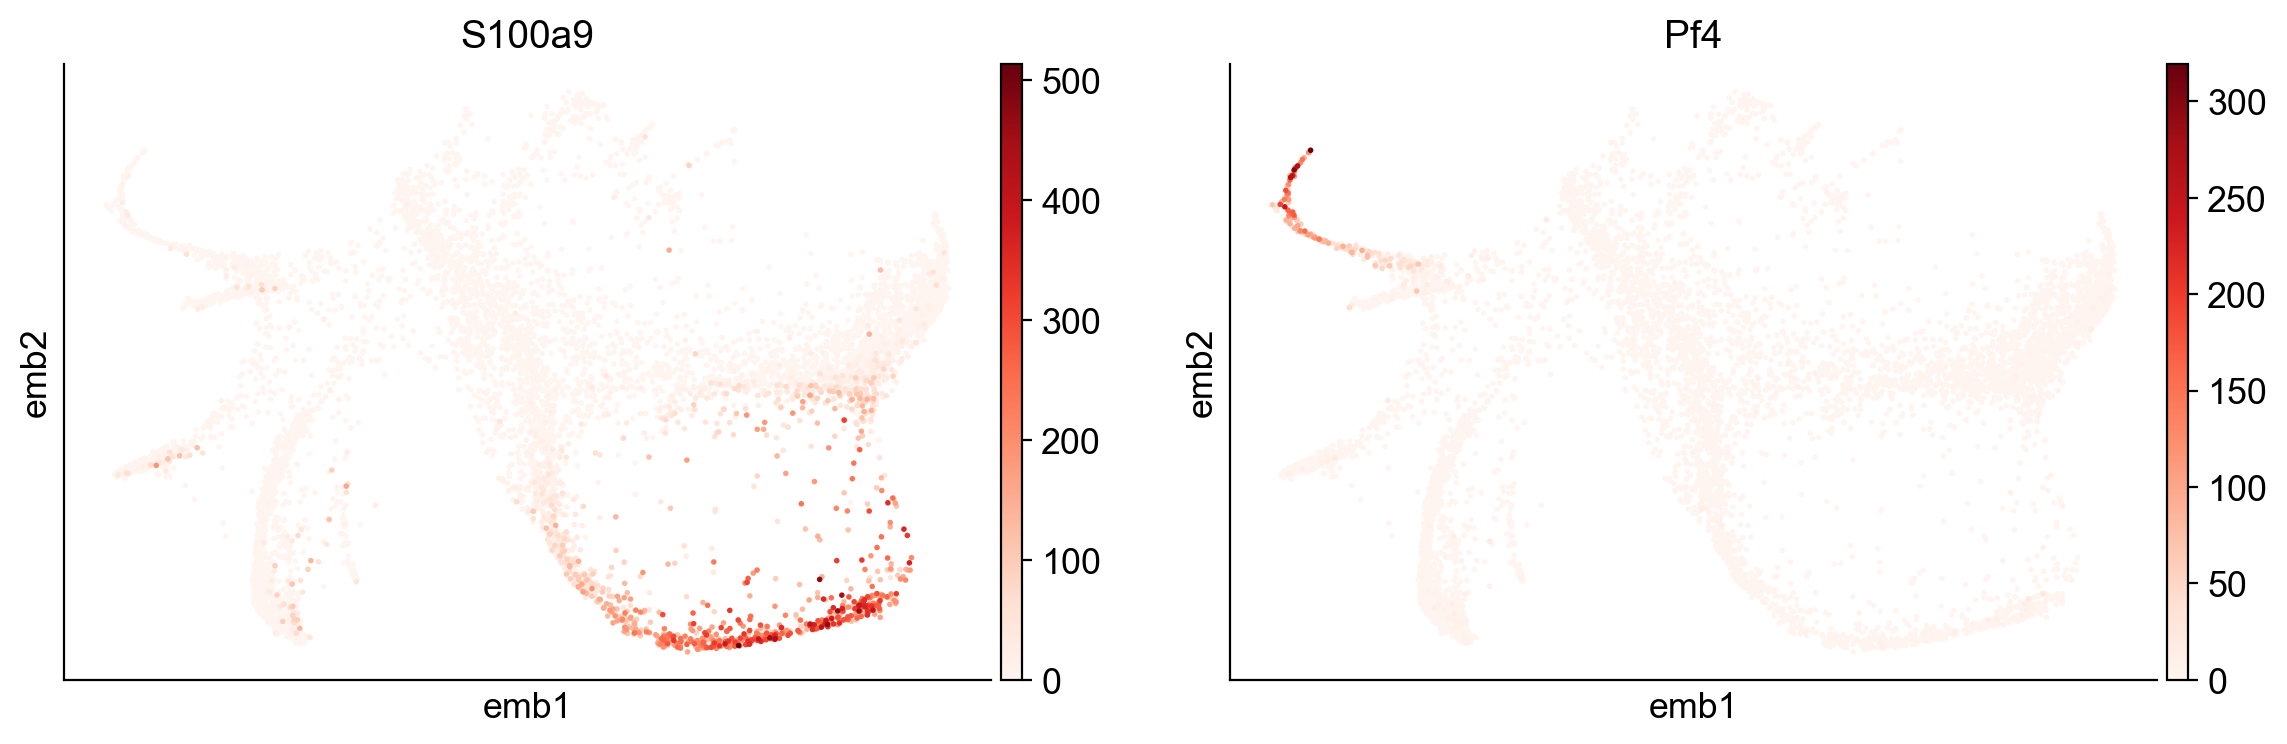

In [220]:
sc.pl.embedding(adata, basis="emb",color=['S100a9', 'Pf4'])

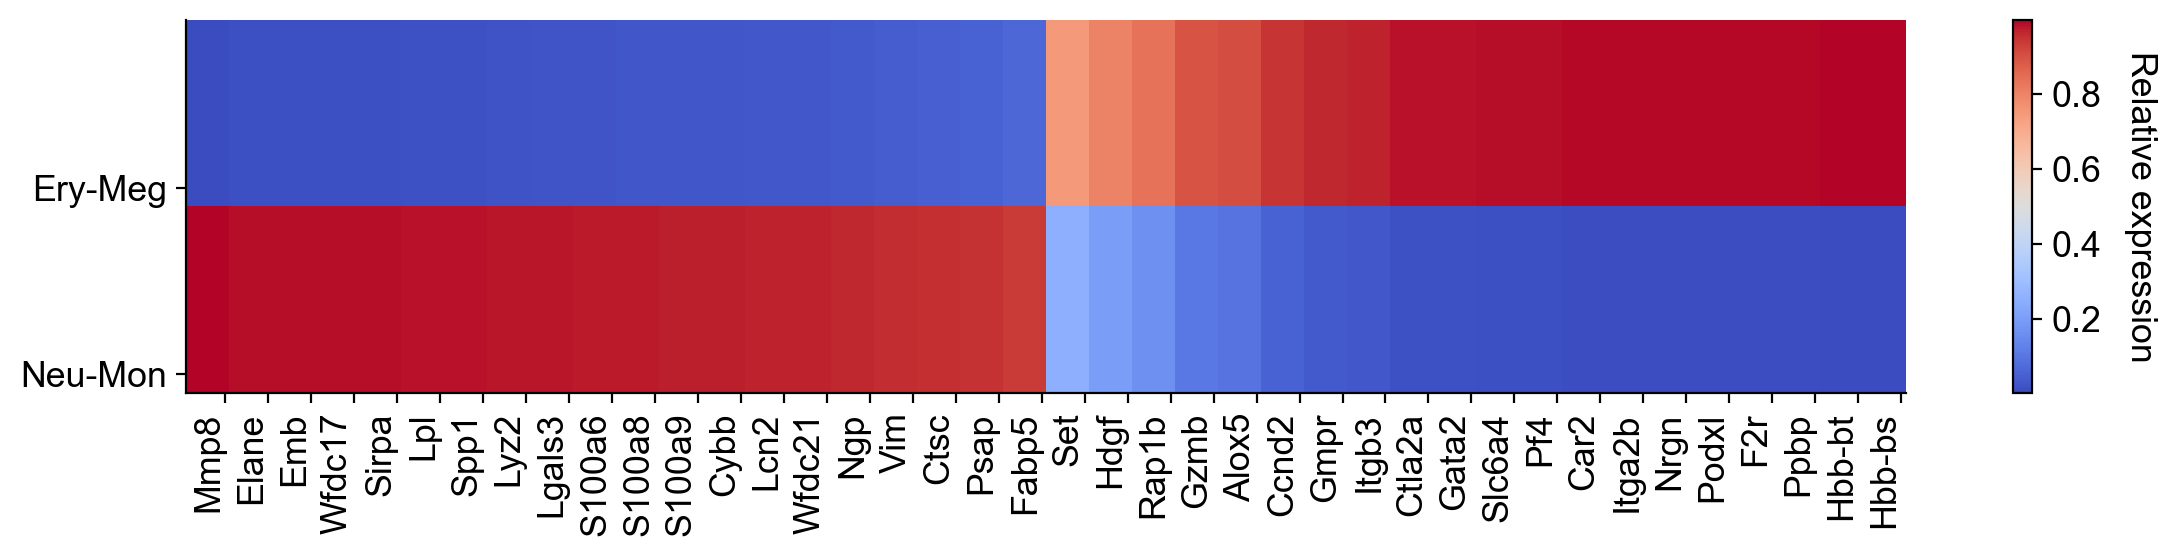

In [221]:
gene_list=list(dge_gene_A['gene'][:20])+list(dge_gene_B['gene'][:20]) #select the top 20 genes from both populations

selected_fates=[['Erythroid','Meg'],['Neutrophil','Monocyte']]
renames=['Ery-Meg', 'Neu-Mon']
gene_expression_matrix=cs.pl.gene_expression_heatmap(adata,selected_genes=gene_list,selected_fates=selected_fates,
                            rename_fates=renames,fig_width=12)

# dges between cell types ery-meg vs neu-mon

In [321]:
# progens dge
cell_group_A=np.array(adata.obs['progenitor_transition_map_Erythroid_Meg'])
cell_group_B=np.array(adata.obs['progenitor_transition_map_Neutrophil_Monocyte'])

In [322]:
dge_gene_A_q2, dge_gene_B_q2=cs.tl.differential_genes(adata,cell_group_A=cell_group_A,cell_group_B=cell_group_B,FDR_cutoff=0.01)
# we can lower the fdr cutoff since we have many genes and the list doesnt shrink that much going from 0.05 to 0.01

In [323]:
dge_gene_A_q2

index       gene        Qvalue    mean_1    mean_2     ratio
0         2      Elane  2.995670e-50  0.137027  6.904547 -2.797417
1         0      Prtn3  9.978032e-57  0.049090  5.145626 -2.550422
2        48     S100a8  1.091572e-18  0.184579  4.612704 -2.244321
3         3       Ctsg  1.152787e-47  0.232535  4.228034 -2.084640
4         5        Mpo  7.907951e-43  0.073894  3.302300 -2.002257
...     ...        ...           ...       ...       ...       ...
1113   1020  Serpinb1a  4.730592e-03  0.719555  0.739901 -0.016970
1114   1013    Aldh9a1  4.673495e-03  0.281057  0.292708 -0.013062
1115    803       Cks2  1.495491e-03  1.269813  1.281950 -0.007694
1116   1211      Srprb  9.323742e-03  0.279912  0.283183 -0.003681
1117   1092      Acadm  6.467634e-03  0.236390  0.237170 -0.000910

[1118 rows x 6 columns]

In [324]:
dge_gene_B_q2[0:10]

index     gene        Qvalue    mean_1    mean_2     ratio
0    122     Gzmb  2.939629e-12  7.862770  0.018404  3.121447
1     42   Hbb-bt  5.872037e-20  4.931711  0.059240  2.485419
2      6    Gata2  1.414227e-41  4.029850  0.097448  2.196362
3    734      Pf4  9.101117e-04  3.734035  0.152029  2.038893
4     21      F2r  5.153943e-28  2.313494  0.066915  1.634908
5     87  Csf2rb2  4.431847e-14  2.223737  0.149880  1.487251
6     26    Alox5  4.964205e-25  1.795180  0.087084  1.362477
7     25   Lgals9  4.604434e-25  3.357222  0.712729  1.347112
8     27    Podxl  3.592389e-24  1.535202  0.012615  1.324015
9     79     Pbx1  3.009260e-15  1.662849  0.106253  1.267289

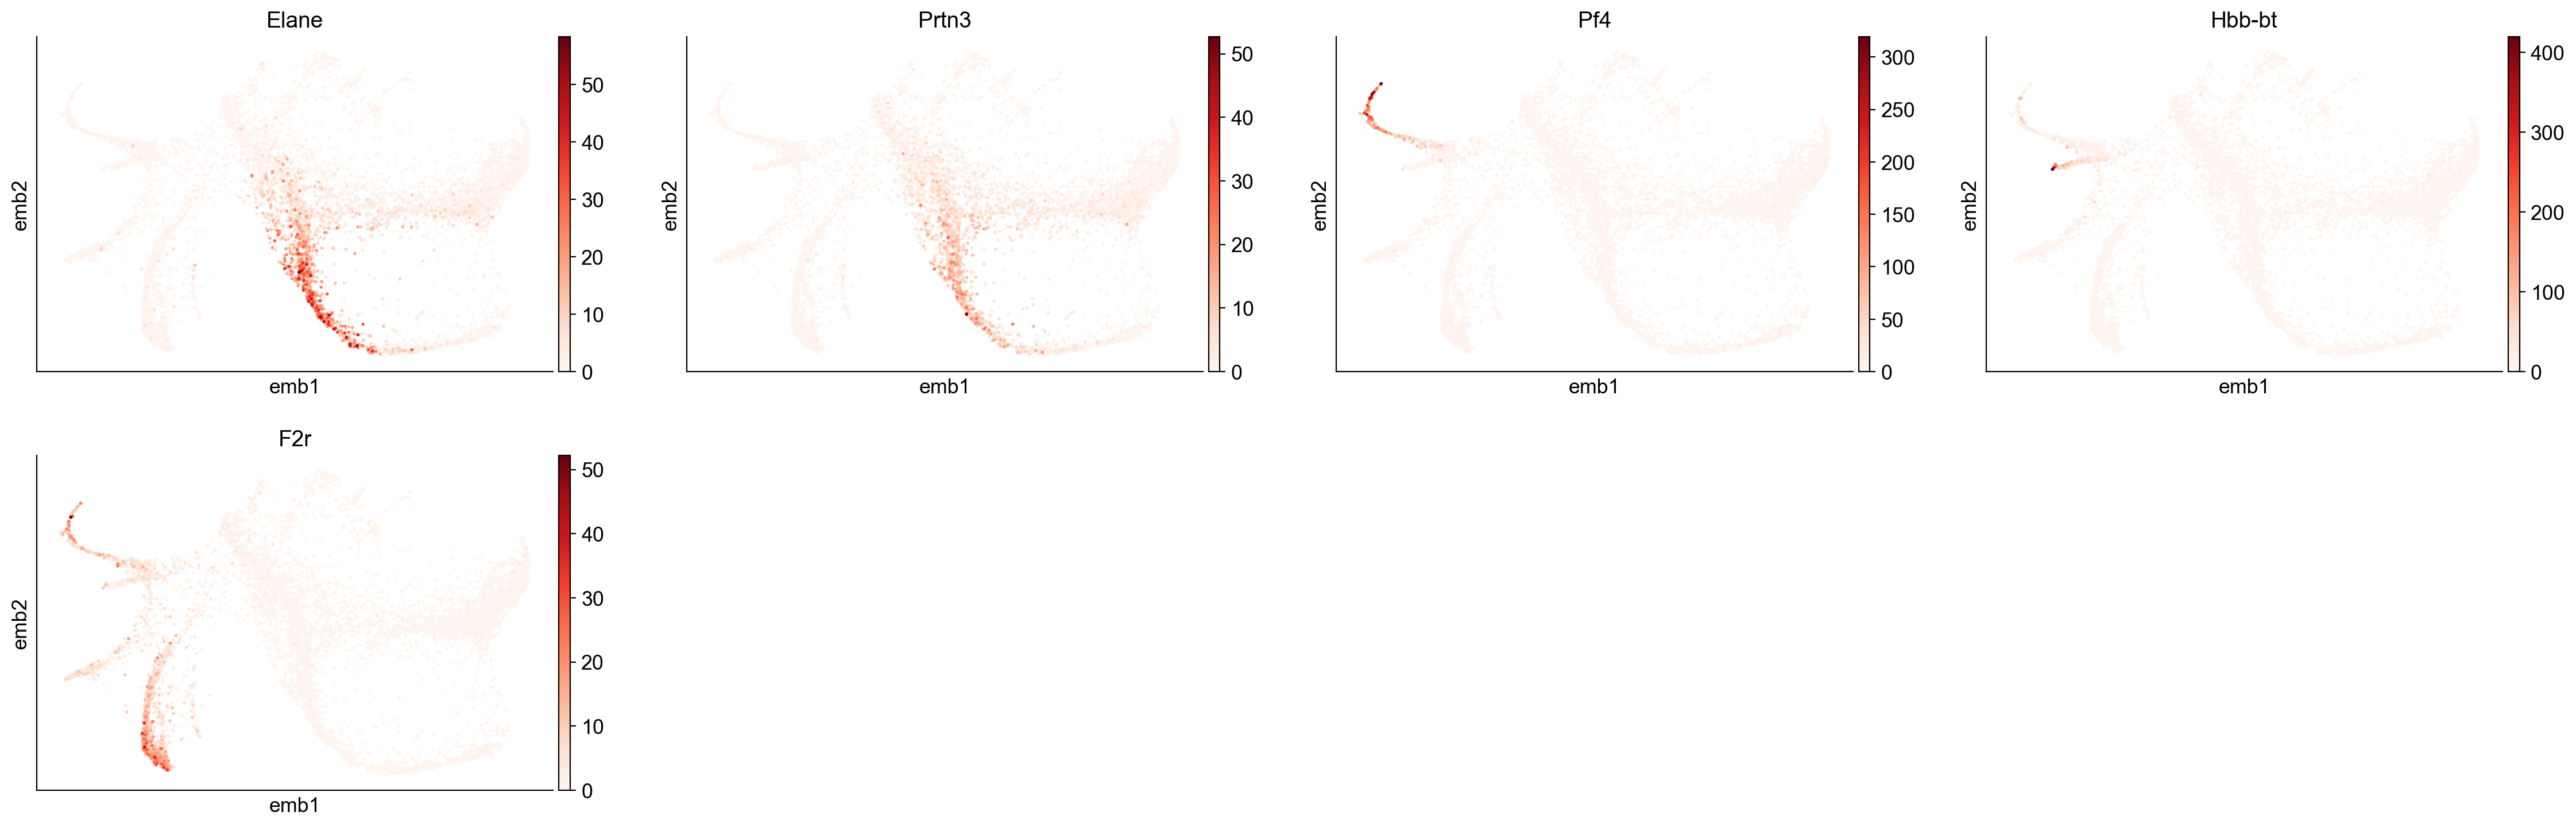

In [334]:
sc.pl.embedding(adata, basis="emb",color=['Elane', 'Prtn3', 'Pf4', 'Hbb-bt', 'F2r'])

In the above graphs, we can seeing a pretty decent split between the two groups with our 4 genes. The only issue is in F2r plot there is are some cells highlighted in mast and baso cell types (this is also the case with some other genes). I think this should be ok though since there are also cells highlighted in eryth and meg and not all genes are going to be exclusive to those two cell types.

# q3

In [274]:
adata.obs['fate_map_transition_map_undiff'].max()

0.039363713428456494

In [256]:
adata.obs['state_info'].value_counts()

undiff        2288
Monocyte      1919
Baso          1398
Neutrophil    1026
Mast           401
Meg            165
Erythroid       83
Eos             54
Lymphoid        40
pDC             25
Neu_Mon         20
Ccr7_DC         19
Name: state_info, dtype: int64

In [259]:
np.quantile(adata.obs['fate_map_transition_map_undiff'], q=0.5)

nan

In [308]:
# we will use the 95th percentile fate potency scores as for undiff cells as the cutoff multipotency
multi_cutoff = np.quantile(adata.obs['fate_map_transition_map_undiff'][~np.isnan(adata.obs['fate_map_transition_map_undiff'])], 0.95)

# cells with a fate potency above or equal to multi_cutoff will be considered multipotent
adata.obs[adata.obs['fate_map_transition_map_undiff'] >= multi_cutoff]

time_info state_info  fate_map_transition_map_Erythroid  \
4439          4     undiff                           0.014918   
7326          4     undiff                           0.000776   
9479          4     undiff                           0.000715   
15573         2     undiff                           0.000579   
16657         2     undiff                           0.000545   
...         ...        ...                                ...   
38274         4     undiff                           0.000702   
38296         4     undiff                           0.001580   
38354         4     undiff                           0.000000   
38412         4     undiff                           0.000463   
38434         4     undiff                           0.000801   

       fate_map_transition_map_Meg  fate_map_transition_map_Baso  \
4439                      0.018193                      0.001218   
7326                      0.003168                      0.000525   
9479                      0.001957                      0.000685   
15573                     0.000170                      0.000792   
16657                     0.000333                      0.001192   
...                            ...                           ...   
38274                     0.002274                      0.000247   
38296                     0.002938                      0.000767   
38354                     0.001232                      0.000072   
38412                     0.001615                      0.000359   
38434                     0.002088                      0.000423   

       fate_map_transition_map_Monocyte  fate_map_transition_map_Ccr7_DC  \
4439                           0.000014                         0.000000   
7326                           0.000232                         0.000617   
9479                           0.000490                         0.000647   
15573                          0.000578                         0.000987   
16657                          0.000776                         0.003210   
...                                 ...                              ...   
38274                          0.000012                         0.000000   
38296                          0.000280                         0.000782   
38354                          0.000009                         0.000000   
38412                          0.000166                         0.000644   
38434                          0.000116                         0.000365   

       fate_map_transition_map_pDC  fate_map_transition_map_Eos  \
4439                           0.0                     0.000653   
7326                           0.0                     0.000659   
9479                           0.0                     0.001366   
15573                          0.0                     0.000000   
16657                          0.0                     0.000052   
...                            ...                          ...   
38274                          0.0                     0.000000   
38296                          0.0                     0.001060   
38354                          0.0                     0.000000   
38412                          0.0                     0.000256   
38434                          0.0                     0.000270   

       fate_map_transition_map_Neutrophil  ...  \
4439                             0.000845  ...   
7326                             0.001875  ...   
9479                             0.002515  ...   
15573                            0.002736  ...   
16657                            0.002778  ...   
...                                   ...  ...   
38274                            0.000882  ...   
38296                            0.001752  ...   
38354                            0.000516  ...   
38412                            0.001568  ...   
38434                            0.001579  ...   

       diff_trajectory_transition_map_Erythroid  \
4439                                  

In [317]:
cell_group_A=np.array(adata.obs['fate_map_transition_map_undiff'] >= multi_cutoff)
cell_group_B=np.array(adata.obs['fate_map_transition_map_undiff'] < multi_cutoff)
dge_gene_A_q3, dge_gene_B_q3=cs.tl.differential_genes(adata,cell_group_A=cell_group_A,cell_group_B=cell_group_B,FDR_cutoff=0.01)

In [318]:
dge_gene_A_q3[0:6]

index    gene        Qvalue    mean_1     mean_2     ratio
0    118  S100a9  1.159161e-10  0.144645  15.535938 -3.852633
1     91  S100a8  2.863098e-12  0.147856  10.951629 -3.380194
2     35    Lyz2  5.047217e-19  0.142061   8.955550 -3.123861
3     68    Ccl6  2.654735e-14  0.047155   5.776702 -2.694109
4    123    Mmp8  3.308881e-10  0.121022   4.137837 -2.196347
5    342    Cpa3  4.430012e-05  0.021620   3.554757 -2.156516

In [319]:
dge_gene_B_q3[0:6]

index   gene        Qvalue    mean_1    mean_2     ratio
0      6   Dlk1  1.294727e-32  5.382966  0.231704  2.373571
1      4   Cd34  8.299333e-35  3.064580  0.297786  1.647054
2     13  H2-Q7  3.541949e-27  3.360602  0.418975  1.619678
3    187  Rsad2  1.295062e-07  2.193712  0.092020  1.548236
4      5   Ly6a  5.138501e-33  4.339679  0.974943  1.434942
5     26  Muc13  5.769146e-21  2.406471  0.321502  1.366099

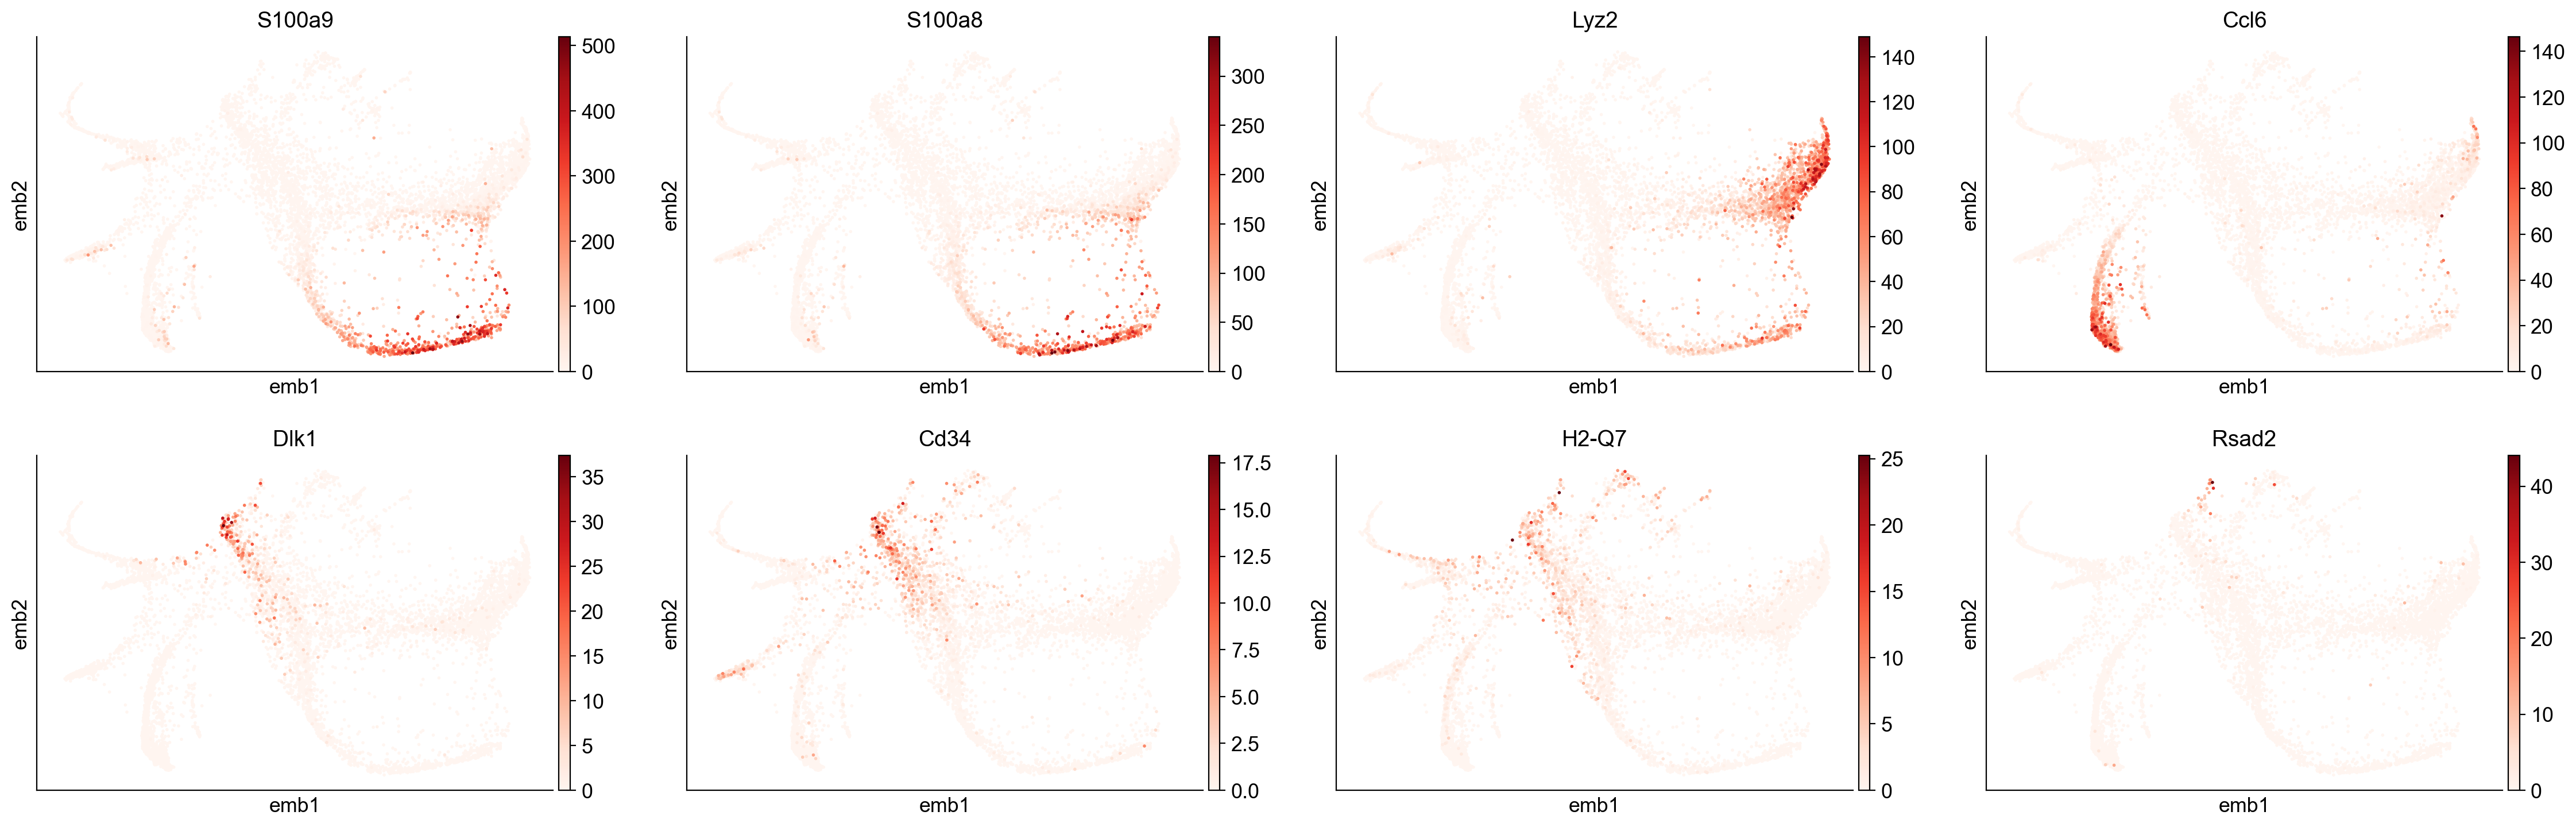

In [320]:
sc.pl.embedding(adata, basis="emb",color=['S100a9', 'S100a8', 'Lyz2', 'Ccl6', 'Dlk1', 'Cd34', 'H2-Q7', 'Rsad2'])

In the top 4 graphs, we can see that the cells are alot more clumped in certain cell types while the bottom 4 genes are more dispersed. The more dispersed cells are more likely to be multipotent. I used the original tl.fate_potency function because we are interested in comparing the fates of the undiff'd cells. To select the cutoff, I played around with different "high" percents to get the best looking graphs (one group with genes expressed in cell that are spread out, one group with gene expressed in cells focused in 1 or 2 branches). 

# q4

In [335]:
from joblib import dump, load 
sigPathTargets = load("signaling_pathway_targets_040122.joblib")

In [343]:
import gseapy as gp

In [379]:
# takes in the list of dge's and runs enrichr with the given sig paths
def enrichmentAnalysis(genesets = {}, gene_list = [], name = ''):
    enr2 = gp.enrichr(gene_list=gene_list,
                  description=name,
                  background=len(gene_list),
                  gene_sets=genesets,
                  outdir='test/'+name,
                  cutoff=0.1,
                  verbose=True)
    return enr2

In [378]:
q1_A = enrichmentAnalysis(sigPathTargets, list(dge_gene_A['gene']), 'q1_A')
q2_A = enrichmentAnalysis(sigPathTargets, list(dge_gene_A_q2['gene']), 'q2_A')
q3_A = enrichmentAnalysis(sigPathTargets, list(dge_gene_A_q3['gene']), 'q3_A')

q1_B = enrichmentAnalysis(sigPathTargets, list(dge_gene_B['gene']), 'q1_B')
q2_B = enrichmentAnalysis(sigPathTargets, list(dge_gene_B_q2['gene']), 'q2_B')
q3_B = enrichmentAnalysis(sigPathTargets, list(dge_gene_B_q3['gene']), 'q3_B')

2022-04-08 19:26:07,212 Connecting to Enrichr Server to get latest library names
2022-04-08 19:26:07,218 No hits return, for gene set: Custom140580324308416
2022-04-08 19:26:07,221 Connecting to Enrichr Server to get latest library names
2022-04-08 19:26:07,246 Save file of enrichment results: Job Id:140580324308416
2022-04-08 19:26:07,249 Warning: No enrich terms using library CUSTOM140580324308416 when cutoff = 0.1
2022-04-08 19:26:07,249 Done.

2022-04-08 19:26:07,250 Connecting to Enrichr Server to get latest library names
2022-04-08 19:26:07,264 Save file of enrichment results: Job Id:140580324308416
2022-04-08 19:26:07,267 Warning: No enrich terms using library CUSTOM140580324308416 when cutoff = 0.1
2022-04-08 19:26:07,267 Done.

2022-04-08 19:26:07,268 Connecting to Enrichr Server to get latest library names
2022-04-08 19:26:07,270 No hits return, for gene set: Custom140580324308416
2022-04-08 19:26:07,270 Connecting to Enrichr Server to get latest library names
2022-04-08 19:2